# Waveform Similarity
This will download seismic waveforms & measure waveform similarity between two data. ObsPy, numpy, scipy, matplotlib are required.

## Import ObsPy module

In [1]:
from obspy import read
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth

from obspy.signal.rotate import rotate_ne_rt
from obspy.signal.rotate import rotate_rt_ne
from obspy.signal.rotate import rotate2zne

import obspy as ob
print("# obspy version = ",ob.__version__)

# obspy version =  1.2.2


## Import SciPy, NumPy, matplotlib module

In [2]:
import numpy as np
import scipy as sp
import matplotlib as mp
print("# numpy version = ",np.__version__)
print("# scipy version = ",sp.__version__)
print("# matplotlib version = ",mp.__version__)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.fftpack import fft, ifft
from scipy import signal
from scipy.linalg import norm
from scipy import ndimage

import sys
import os


# numpy version =  1.19.1
# scipy version =  1.5.2
# matplotlib version =  3.3.1


## Font size

In [3]:
# font size
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

#SMALL_SIZE = 32
#MEDIUM_SIZE = 32
#BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## function: get_seedid
to extract seed_id from obspy stream.

In [4]:
def get_seedid (tr):
    seedid=tr.stats.network+"."+tr.stats.station+"."+tr.stats.location+"."+tr.stats.channel
    return seedid

## function: st_remove_resp
to correct instrument response.

In [5]:
def st_remove_resp (st, deciopt, decifactor, pre_filt, output):
    st.detrend() # remove linear trend
    st.detrend("demean") # demean
    st.taper(0.05) # cosin taper

    if deciopt == 1:
        # decimate to 100Hz
        if decifactor == 100:     
            st.decimate(5, strict_length=False)
            st.decimate(2, strict_length=False)

            st.decimate(5, strict_length=False)
            st.decimate(2, strict_length=False)

        else:
            st.decimate(factor=decifactor, strict_length=False)
    
    st = st.remove_response(pre_filt=pre_filt,output=output,water_level=None) # get velocity data (m/s)

    return st


## function: get_sta_coord
to extract station coordinate from obspy stream.

In [6]:
def get_sta_coord (seedid, inv, starttime):
    sta_coordinate = inv.get_coordinates(seedid, starttime)
    return sta_coordinate


## function: get_sta_orientation
to extract sensor orientation from obspy stream.

In [7]:
def get_sta_orientation (seedid, inv, starttime):
    sta_orientation = inv.get_orientation(seedid, starttime)
    return sta_orientation


## function: get_zne_data
to rotate 3-com data into ZNE coordinate

In [8]:
def get_zne_data (st, inv, starttime):

    st_len = len(st)
    
    if st_len != 3:
        print("# cannot do!")
        

    sta_coordinate = []
    sta_orientation = []

    #for tr in st1:
    for i, tr in enumerate(st, 1):
        #print("# i = ",i)
        seedid=get_seedid(tr)
        #sta_coordinate[i] = get_sta_coord(tr, seedid, inv1, starttime)

        sta_coordinate.append(get_sta_coord(seedid, inv, starttime))
        sta_orientation.append(get_sta_orientation(seedid, inv, starttime))

        #print("# seedid = ",seedid, sta_coordinate)
        #print("# seedid = ",seedid, sta_orientation)

    ztmp = st[2]
    AzZ = sta_orientation[2]['azimuth']
    DipZ = sta_orientation[2]['dip']
    #print("# AzZ = ", AzZ, " DipZ = ", DipZ)
    
    ntmp = st[1]
    AzN = sta_orientation[1]['azimuth']
    DipN = sta_orientation[1]['dip']
    #print("# AzN = ", AzN, " DipN = ", DipN)

    etmp = st[0]
    AzE = sta_orientation[0]['azimuth']
    DipE = sta_orientation[0]['dip']
    #print("# AzE = ", AzE, " DipE = ", DipE)

    
    t1z , t1n, t1e = rotate2zne(ztmp,AzZ,DipZ,ntmp,AzN,DipN,etmp,AzE,DipE)
    st[0].data = t1e
    st[1].data = t1n
    st[2].data = t1z
    #i_1.stats.channel[:-1] + \
    #                output_components[0]
    st[0].stats.channel = st[0].stats.channel[:-1] + "E"
    st[1].stats.channel = st[0].stats.channel[:-1] + "N"
    st[2].stats.channel = st[0].stats.channel[:-1] + "Z"

    return st


## function: get_baz
to compuete back-azimuth

In [9]:
def get_baz (st, inv, evla, evlo):
    seedid=get_seedid(st[0])
    sta_coord = get_sta_coord(seedid,inv,starttime)
    
    stla = sta_coord['latitude']
    stlo = sta_coord['longitude']
    
    source_latitude = evla
    source_longitude = evlo
    
    station_latitude = stla
    station_longitude = stlo
    
    # theoretical backazimuth and distance
    baz = gps2dist_azimuth(source_latitude, source_longitude, station_latitude, station_longitude)

    #print('Epicentral distance [m]: ', baz[0])
    #print('Theoretical azimuth [deg]: ', baz[1])
    #print('Theoretical backazimuth [deg]: ', baz[2])
    
    return baz

## function: waveform_comparison
will add coherency later

In [10]:
def waveform_comparison (st, plotOPT):
    sncl1 = get_seedid(st[0])
    sncl2 = get_seedid(st[1])
    #print("# sncl1 = ", sncl1)
    #print("# sncl2 = ", sncl2)
    plot_fi = plot_dir+"/"+sncl2+"_"+sncl1+"_"+event_para+".pdf"
    #print("# plot_fi = ",plot_fi)

    T1=st[0].stats.delta
    N1=st[0].stats.npts
    xf1 = np.linspace(0.0, 1.0/(2.0*T1), N1//2)
    yf1 = fft(st[0].data)

    T2=st[1].stats.delta
    N2=st[1].stats.npts
    xf2 = np.linspace(0.0, 1.0/(2.0*T2), N2//2)
    yf2 = fft(st[1].data)

    yf1_amp =  2.0/N1 * np.abs(yf1)
    yf2_amp =  2.0/N2 * np.abs(yf2)
    
    # no div N1 or N2 match sac results....
    yf1_amp =  2.0/1.0 * np.abs(yf1)
    yf2_amp =  2.0/1.0 * np.abs(yf2)
    
    index_select = np.where(  (fl <= xf2) & (xf2 <= fh) )
    #yf1_amp_max = np.amax(yf1_amp[index_select])
    #yf2_amp_max = np.amax(yf2_amp[index_select])
    #print("# yf1_amp_max = ", yf1_amp_max)
    #print("# yf2_amp_max = ", yf2_amp_max)
    yf_amp_max =  np.amax(np.concatenate((yf1_amp[index_select], yf2_amp[index_select]) ))
    #print("# yf_amp_max = ", yf_amp_max)
    yf_amp_min =  np.amin(np.concatenate((yf1_amp[index_select], yf2_amp[index_select]) ))
    #print("# yf_amp_min = ", yf_amp_min)
    yf_amp_max2 = yf_amp_max * 5
    yf_amp_min2 = yf_amp_min * 0.5

    #set amfactor = 5
    #set samaxIn = `cat depmax.out | grep depmax | awk '{print $3+0}' | head -1 | awk -v amfactor=$amfactor '{val=$1*amfactor; printf("%e\n",val); }' `
    #set saminIn = `echo $samaxIn | awk '{val=$1*-1; printf("%e\n",val); }' `
    #set amfactor = 0.5
    #set saminIn = `cat depmin.out | grep depmin | awk '{print $3+0}' | tail -1 | awk -v amfactor=$amfactor '{val=$1*amfactor; printf("%e\n",val); }' `


    yf_amp_ratio = yf2_amp / yf1_amp

    #print(np.where(a < 4, -1, a))

    #index200 = np.where( (190 <= periods) & (periods <= 210) )

    #index_select_num = index_select.shape
    #print("# index_select = ", index_select)         
    index_select_num = yf_amp_ratio[index_select].shape[0]
    #print("# index_select_num = ", index_select_num)

    #print("# yf_amp_ratio[index_select] = ", yf_amp_ratio[index_select])
    amp_median = ndimage.median(yf_amp_ratio[index_select])
    amp_l1 = norm(yf_amp_ratio[index_select]-amp_median, 1)/index_select_num

    #print("# amp_median = ",amp_median," amp_l1 = ", amp_l1)
    amp_l1_out = "{:.3f}".format(amp_l1)
    amp_median_out = "{:.3f}".format(amp_median)

    #print("# amp_median_out = ",amp_median_out," amp_l1_out = ", amp_l1_out)

    yf1_ph = np.angle(yf1)
    yf2_ph = np.angle(yf2)
    
    
    yf1_ph = np.where(yf1_ph <= -np.pi,  yf1_ph + 2*np.pi,  yf1_ph)
    yf1_ph = np.where (np.pi <= yf1_ph,  yf1_ph - 2*np.pi,  yf1_ph)

    yf2_ph = np.where(yf2_ph <= -np.pi,  yf2_ph + 2*np.pi,  yf2_ph)
    yf2_ph = np.where (np.pi <= yf2_ph,  yf2_ph - 2*np.pi,  yf2_ph)

    yf_ph_diff = yf2_ph - yf1_ph

  
    # phase diff also. need to check it later
    #print("#  yf_ph_diff[index_select] = ",  yf_ph_diff[index_select])
    #print("# max = ",np.amax(yf_ph_diff[index_select]))
    yf_ph_diff = np.where(yf_ph_diff <= -np.pi,  yf_ph_diff + 2*np.pi,  yf_ph_diff)
    yf_ph_diff = np.where (np.pi <= yf_ph_diff,  yf_ph_diff - 2*np.pi,  yf_ph_diff)
    #print("#  yf_ph_diff[index_select] = ",  yf_ph_diff[index_select])
    #print("# max = ",np.amax(yf_ph_diff[index_select]))
    
    ph_median = ndimage.median(yf_ph_diff[index_select])
    ph_l1 = norm(yf_ph_diff[index_select]-ph_median, 1)/index_select_num
    
    #print("# ph_median = ",ph_median," ph_l1 = ", ph_l1)
    ph_l1_out = "{:.3f}".format(ph_l1)
    ph_median_out = "{:.3f}".format(ph_median)



    #echo "# wmaxIn & wminIn are overwritted!"
    #set wmaxIn = `cat depmax.out | grep depmax | awk '{print $3+0}' | head -1 | awk -v amfactor=$amfactor '{val=$1*amfactor; printf("%e\n",val); }' `
    #set wminIn = `echo $wmaxIn | awk '{val=$1*-1; printf("%e\n",val); }' `
    #echo "# wminIn = "$wminIn" wmaxIn = "$wmaxIn

    yf_amp_max =  np.amax(np.concatenate((yf1_amp[index_select], yf2_amp[index_select]) ))

    data_all = np.concatenate((st[0].data, st[1].data) )
    wf_amp_max = max(data_all.min(), data_all.max(), key=abs)
    #print("# wf_amp_max = ", wf_amp_max)
    wf_amp_max2 = wf_amp_max * 1.1
    wf_amp_min2 = wf_amp_max2 * -1
    
    if plotOPT: 
        #plt.rcParams['figure.figsize'] = 16, 16


        gs = gridspec.GridSpec(3,2)
        #gs = gridspec.GridSpec(6,2)

        #fig = plt.figure()
        fig = plt.figure(figsize=(16, 16))


        #fig.text(0.41, 0.3, 'leftbottom4',ha='right')
        #fig.text(0.42, 0.3, 'leftbottom5',ha='right')
        #fig.text(0.34, 0.3, 'leftbottom6',ha='right')

        t=fig.text(0.13, 0.86, str(fl)+"-"+str(fh)+" Hz BP filter")
        t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

        t=fig.text(0.44, 0.3, "Median: "+str(amp_median_out), ha='right')
        t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))
        t=fig.text(0.44, 0.280, "L1 norm: "+str(amp_l1_out), ha='right')
        t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

        t=fig.text(0.89, 0.160, "Median: "+str(ph_median_out), ha='right')
        t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))
        t=fig.text(0.89, 0.140, "L1 norm: "+str(ph_l1_out), ha='right')
        t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

        
        #fig.text(1, 0, 'rightbottom', ha='right')
        #fig.text(0, 1, 'lefttop', va='top')
        #fig.text(1, 1, 'righttop', ha='right', va='top')
        plt.subplots_adjust(wspace=0.4, hspace=0.4)

        ### waveforms 
        #plt.subplot(211)
        plt.subplot(gs[0, :])
        #plt.plot(st[0].times("matplotlib"), st[0].data*1,label=sncl1, color="red", linewidth=0.75)
        #plt.xaxis_date()
        plt.plot_date(st[0].times("matplotlib"), st[0].data*1, fmt='-', label=sncl1, color="red",  linewidth=0.75, linestyle='solid')
        plt.plot_date(st[1].times("matplotlib"), st[1].data*1, fmt='-', label=sncl2, color="blue", linewidth=0.75, linestyle='solid')

        import matplotlib.dates as mdates 
        myFmt = mdates.DateFormatter("%D/%H:%M") 
        #mdates.DateFormatter("%Y-%m-%d\n%H:%M:%S")
        myFmt = mdates.DateFormatter("%Y-%m-%d\n%H:%M:%S") 
        plt.gca().xaxis.set_major_formatter(myFmt) 


        plt.xlim(st[0].times("matplotlib")[0], st[0].times("matplotlib")[-1])
        plt.ylim(wf_amp_min2 , wf_amp_max2 )
        plt.grid()

        #plt.title("Waveform comparison")
        #
        #Mw:7.8 ALASKA-PENINSULA
        #plt.title("Origin Time:2020-07-22T06:12:44 IRIS event-id:11273635 \n Mw:7.8 ALASKA-PENINSULA ")
        plt.title(event_para+" \n Origin Time:"+str(origin_time)+" USGS event-id:"+evid+" \n M"+str(evmag)+" "+event_region)

        #plt.text(0.1, 0.9,'matplotlib', ha='center', va='center') 
        #plt.text(x, y, s, bbox=dict(facecolor='red', alpha=0.5))
        
        #plt_pos = plt.get_position()
        #fig = plt.figure()
        #ax = plt.axes()
        #txt = plt.text(0.1,0.5,"My text", transform = ax.transAxes)
        #txt = plt.text(0.1,0.5,"My text")

        plt.ylabel("Amplitude (m/s)")
        #plt.xlabel("Time")
        plt.legend(loc = "upper right")
        #plt.legend(loc="upper left")
        ### waveforms 
        
        ### amplitude spectra
        #plt.subplot(313)
        plt.subplot(gs[1,0])

        plt.plot(xf1, (yf1_amp[0:N1//2]), label=sncl1, color="red", linewidth=0.75)
        plt.plot(xf2, (yf2_amp[0:N2//2]), label=sncl2, color="blue", linewidth=0.75)
        plt.xlim(fl,fh)
        plt.ylim(yf_amp_min2, yf_amp_max2)
        plt.grid()
        #plt.rc('axes.formatter', useoffset=False)
        #plset_major_formatter(mticker.ScalarFormatter()) 
        #ax.ticklabel_format(useOffset=False, style='plain')
        #matplotlib.pyplot.ticklabel_format(*, axis='both', style='', scilimits=None, useOffset=None, useLocale=None, useMathText=None)
        #plt.ticklabel_format(useOffset=False, style='plain')
        
        #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        #plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
        
        plt.yscale("log")
        #plt.xscale("log")
  
        #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        #plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
        
        plt.title("Amplitude spectra")
        plt.ylabel("Amplitude (m$^2$/s$^2$/Hz)")
        plt.xlabel("Frequency (Hz)")
        plt.legend(loc = "upper right")
        ### amplitude spectra

        ### phase spectra
        plt.subplot(gs[1,1])
        plt.plot(xf1, (yf1_ph[0:N1//2]), label=sncl1, color="red", linewidth=0.75)
        plt.plot(xf2, (yf2_ph[0:N2//2]), label=sncl2, color="blue", linewidth=0.75)
        
        plt.xlim(fl,fh)
        plt.ylim(-4,4)
        plt.grid()

        #plt.yscale("log")
        #plt.xscale("log")

        plt.title("Phase spectra")
        plt.ylabel("Phase (rad)")
        plt.xlabel("Frequency (Hz)")
        plt.legend(loc = "upper right")     
        ### phase spectra
        
        ### amplitude ratio
        plt.subplot(gs[2,0])

        
        plt.plot(xf1, (yf_amp_ratio[0:N1//2]), color="black", linewidth=0.75)
        plt.plot([fl, fh], [amp_median, amp_median], color="black", linewidth=1.25, linestyle="dashed")

        plt.xlim(fl,fh)
        plt.ylim(0.5,1.5)
        plt.grid()

        #plt.yscale("log")
        #plt.xscale("log")


        plt.title("Spectral amplitude ratio")
        plt.ylabel("Amp. ("+sncl2+"/"+sncl1+")")       
        plt.xlabel("Frequency (Hz)")


        #plt.legend()
        ### amplitude ratio
        
        ### phase diff
        plt.subplot(gs[2,1])

        plt.plot(xf1, (yf_ph_diff[0:N1//2]), color="black", linewidth=0.75)
        plt.plot([fl, fh], [ph_median, ph_median], color="black", linewidth=1.25, linestyle="dashed")

        plt.xlim(fl,fh)
        plt.ylim(-1.0,1.0)
        #plt.ylim(-7.0,7.0)
        plt.grid()

        #plt.yscale("log")
        #plt.xscale("log")


        plt.title("Difference in spectral phase")
        plt.ylabel("Phase ("+sncl2+"-"+sncl1+")")
        plt.xlabel("Frequency (Hz)")
        #plt.legend()
        ### phase diff
        
        plt.savefig(plot_fi) 


## Set client (Data Center) for event search
This example uses USGS. We can use other dataceneter (e.g., NCEDC, IRIS)

In [11]:
#clientEQ = Client("IRIS")
clientEQ = Client("USGS")

## Event search
Set time window (st, et) and a range of magunitude (minmag, maxmag). This example will find the 22 July 2020 M 7.8 Alaska event.

1 Event(s) in Catalog:
2020-07-22T06:12:44.719000Z | +55.068, -158.554 | 7.8 mww | manual


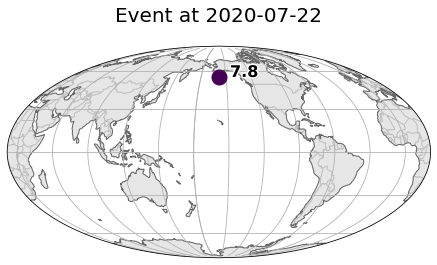

In [12]:
#M 7.8 - Alaska Peninsula
#2020-07-22 06:12:44 (UTC)55.068°N 158.554°W28.0 km depth
#https://earthquake.usgs.gov/earthquakes/eventpage/us7000asvb/executive
st = UTCDateTime("2020-07-22T00:00:00")  # 
et = UTCDateTime("2020-07-23T00:00:00")  #
minmag = 7.0
maxmag = 9.9

catalog = clientEQ.get_events(starttime=st , endtime=et,
                            minmagnitude=minmag, maxmagnitude=maxmag)
print(catalog)

_plot = catalog.plot()


## Extract event information


In [13]:
# event info. origin time, location, magnitude
event = catalog[0]
origin = event.origins[0]
origin_time = origin.time
evla = origin.latitude
evlo = origin.longitude
evdp_km = origin.depth / 1000
evmag = event.magnitudes[0].mag

evyearOUT = origin_time.year
evjdayOUT = origin_time.julday
evhourOUT = origin_time.hour
evminOUT = origin_time.minute
evsecOUT = origin_time.second

evid = event.origins[0]['extra']['dataid']['value']
event_region = event.event_descriptions[0]['text']

In [14]:
# need for file name
evyearOUT2 = (str)(evyearOUT)
evjdayOUT2 = (str)(evjdayOUT)
if evjdayOUT < 100:
    evjdayOUT2 = "0"+(str)(evjdayOUT)
        

if evjdayOUT < 10:
    evjdayOUT2 = "00"+(str)(evjdayOUT)
    

evhourOUT2 = (str)(evhourOUT)
if evhourOUT < 10:
    evhourOUT2 = "0"+(str)(evhourOUT)
        

evminOUT2 = (str)(evminOUT)
if evminOUT < 10:
    evminOUT2 = "0"+(str)(evminOUT)


evsecOUT2 = (str)(evsecOUT)
if evsecOUT < 10:
    evsecOUT2 = "0"+(str)(evsecOUT)
        
        
#print("# evyearOUT2 = ",evyearOUT2," evjdayOUT2 = ",evjdayOUT2," evhourOUT2 = ",evhourOUT2," evminOUT2 = ",evminOUT2," evsecOUT2 = ",evsecOUT2)
    
evmseedid = evyearOUT2+"."+evjdayOUT2+"."+evhourOUT2+""+evminOUT2+""+evsecOUT2
#print("# evmseedid = "+evmseedid)

event_para = evmseedid +"_M"+(str)(evmag)+"_"+(str)(evid)


## Directory for waveform plot
This example will create directory "2020.204.061244_M7.8_us7000asvb" where all plots will be saved.

In [15]:
# name for output directory
pwd_dir = os.getcwd() 
#sacdir= pwd_dir +"/"+ evmseedid +"_M"+(str)(evmag)+"_"+(str)(eventid_ncedc)+"_fl"+(str)(f2)+"_fh"+str(f3)+"_dist"+(str)(distkm_from_eq)+"km"
#plot_dir= pwd_dir +"/"+ evmseedid +"_M"+(str)(evmag)+"_"+(str)(evid)
#+"_fl"+(str)(f2)+"_fh"+str(f3)+"_dist"+(str)(distdeg_from_eq)+"deg"


plot_dir= pwd_dir +"/"+ event_para

print("# plot_dir = ",plot_dir)

# create output directory
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)


# plot_dir =  /Users/taira/work/python_work/2020.204.061244_M7.8_us7000asvb


## Set time window for downloading seismic data
This example extracts 90-min data for the 2020 M 7.8 Alaska earthquake

In [16]:
pre_tw = 0 # 0s if this is -10, then data from -10s from the origin time
stw = 90*60 # 90 min from the starting time (oriting_time + pre_tw)

starttime = origin_time + pre_tw  
endtime = starttime + stw

#print("# starttime = ",starttime)

## Set SNCL parameters
Which SNCL (Station, Network, Component, Location) we will use? sta1,net1,com1,loc1 for the target data, sta2,net2,com2,loc2 for the reference data.

In [17]:
sta1 = "BRK" # station

net1 = "BK" # network
com1 = "HH?" # component "HH?" to get all 3-com data from broadband sensor
loc1 = "00" # location

deciopt_1 = 1
#decifactor_1 = 100 # 100sps -> 1sps
decifactor_1 = 10 # 100sps -> 10 sps

client1 = Client("NCEDC") # data from NCEDC

In [18]:
sta2 = "BRK" # station

net2 = "BK" # network
com2 = "HN?" # component "HN?" to get all 3-com data from strong-motion sensor
loc2 = "00" # location

deciopt_2 = 1
#decifactor_2 = 100
decifactor_2 = 10

client2 = Client("NCEDC") # data from IRIS

## Set time window for waveform similarity

In [19]:
Rvel = 4.2 # surface wave velocity (km/s) 
tw_pre_tw = -500 # sec before Rwave_arrival
tw_trim = 2000 # 2000-s window length


## Set frequency range for waveform similarity
set the frequency range (fl and fh) for waveform similarity analysis. This example will use 0.02-0.10 Hz band. Also this will use for pre-filter when we correct the instrument response.

In [20]:
#fl2 < fl < fh < fh2

fl2 = 0.01 # Hz
fl = 0.02 # Hz 
fh = 0.10 #  Hz
fh2 = 0.20 # Hz


#pre_filt = [0.015, 0.02, 45, 50]
pre_filt = [fl2, fl, fh, fh2]

## Downloading seismic data
use get_waveforms to download data and do st.plot() for plotting. Also use get_stsations to obtation station inventory file. 

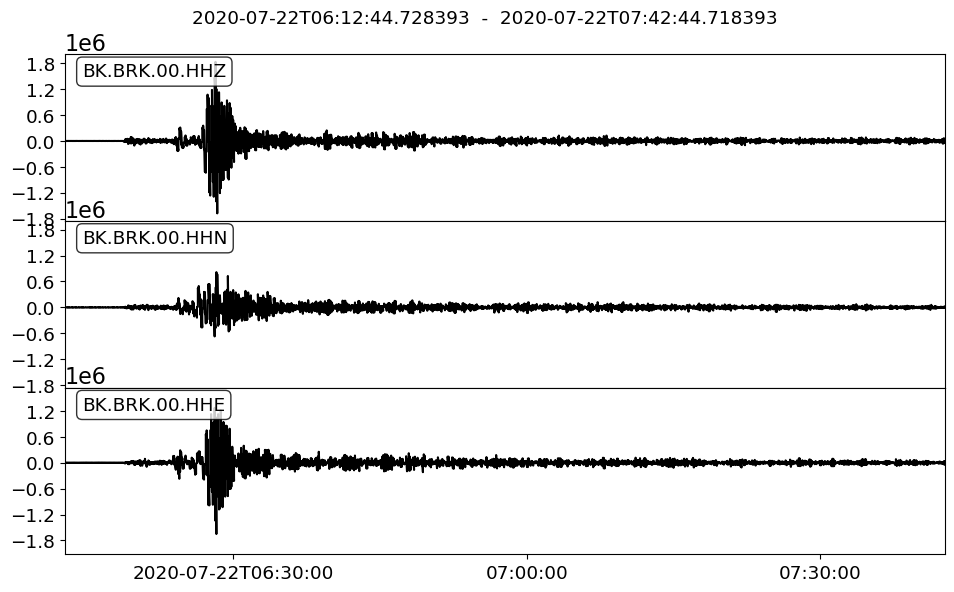

In [21]:
st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                     starttime=starttime, endtime=endtime, 
                     attach_response=True)
inv1 = client1.get_stations(network=net1, station=sta1, location=loc1, channel=com1,
                     starttime=starttime, endtime=endtime, 
                     level="response")
_plot = st1.plot(size=(1000,600))
#_plot = st1.plot()


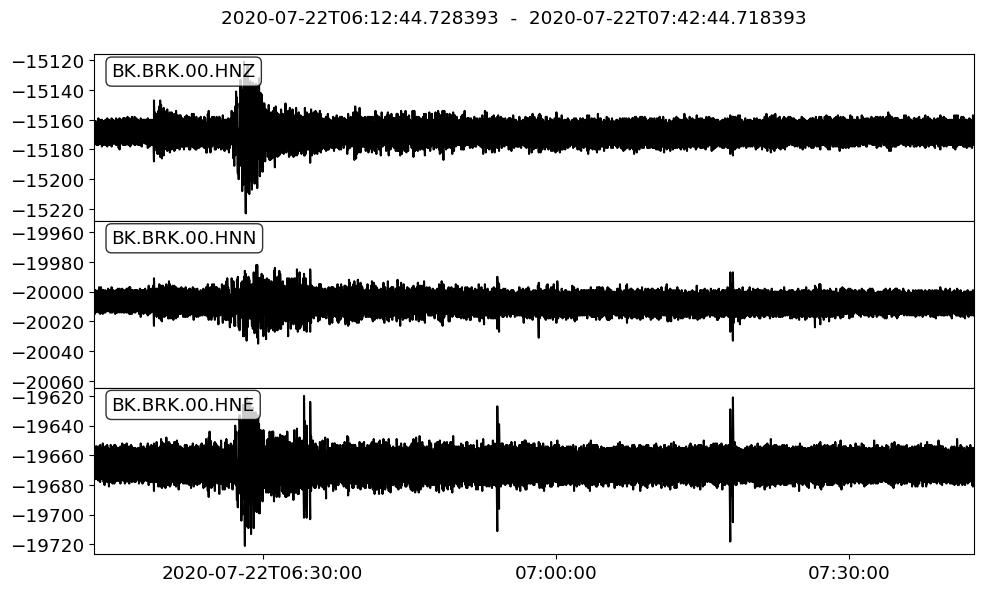

In [22]:
st2 = client2.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                     starttime=starttime, endtime=endtime, 
                     attach_response=True)


# for station locations
inv2 = client2.get_stations(network=net2, station=sta2, location=loc2, channel=com2,
                     starttime=starttime, endtime=endtime, 
                     level="response")

_plot = st2.plot(size=(1000,600))

## Removing instrument response 
use st_remove_resp function uses obspy remove_response to remove instrument response. Example will provide ground velocity data (m/s)

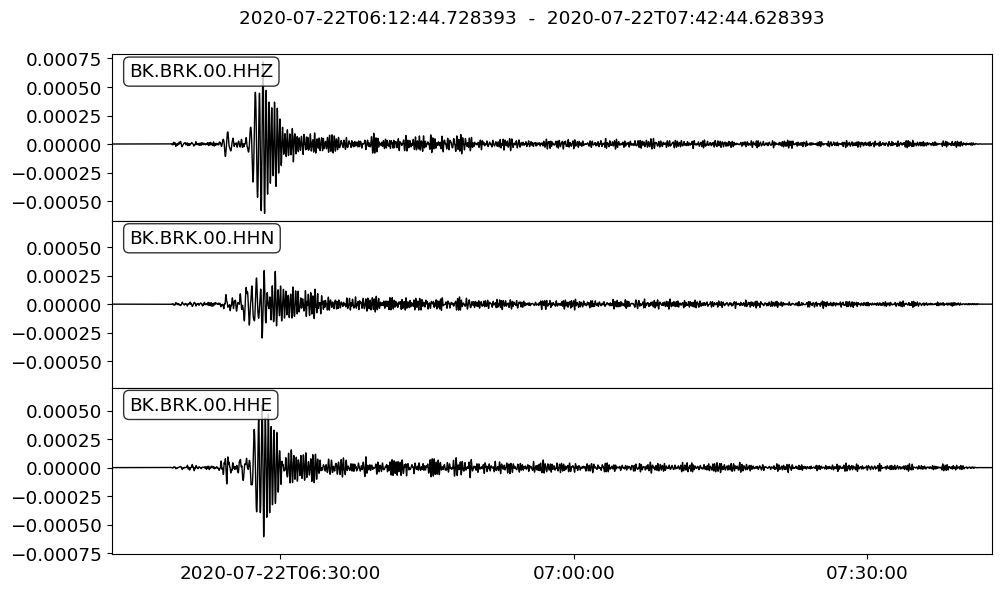

In [23]:
st1 = st_remove_resp(st1, deciopt_1, decifactor_1, pre_filt, "VEL")
_plot = st1.plot(size=(1000,600))

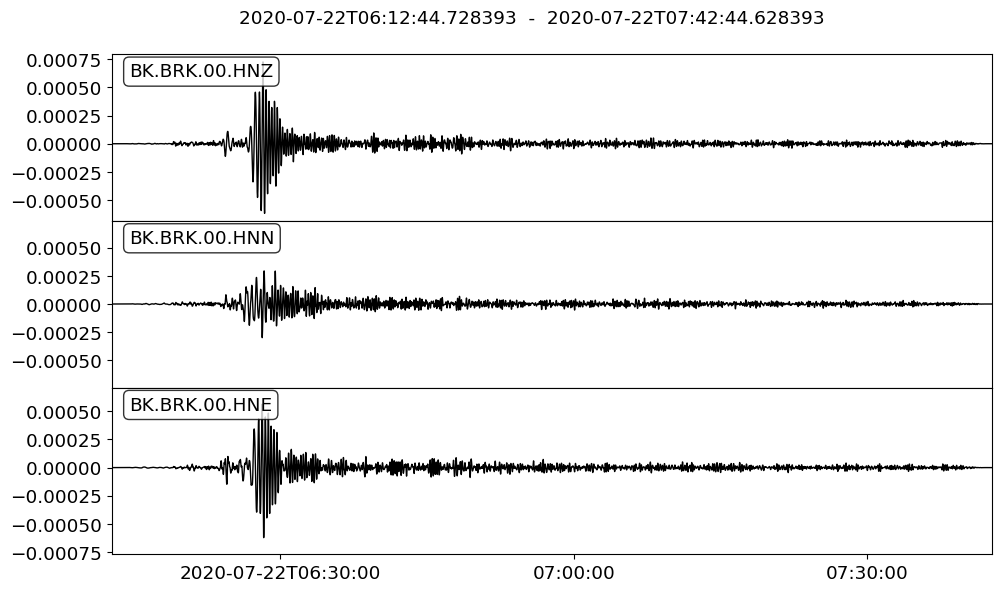

In [24]:
st2 = st_remove_resp(st2, deciopt_2, decifactor_2, pre_filt, "VEL")
_plot = st2.plot(size=(1000,600))

## Rotating seismic data into ZNE coordinate
use get_zne_data. This will provide ZNE coordinate data. 

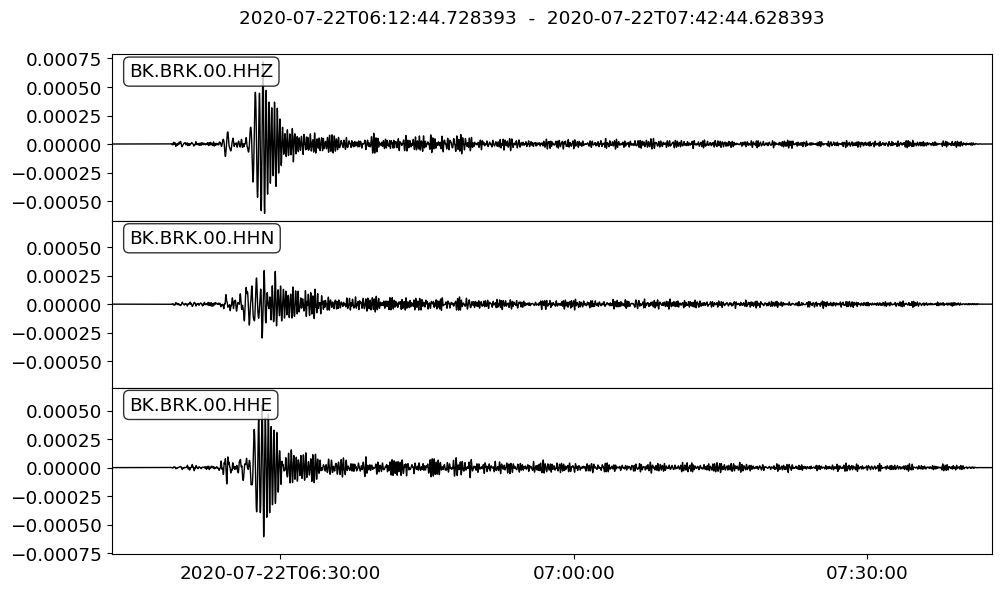

In [25]:
st1_zne = st1.copy()
st1_zne = get_zne_data (st1_zne, inv1, starttime)
_plot = st1_zne.plot(size=(1000,600))

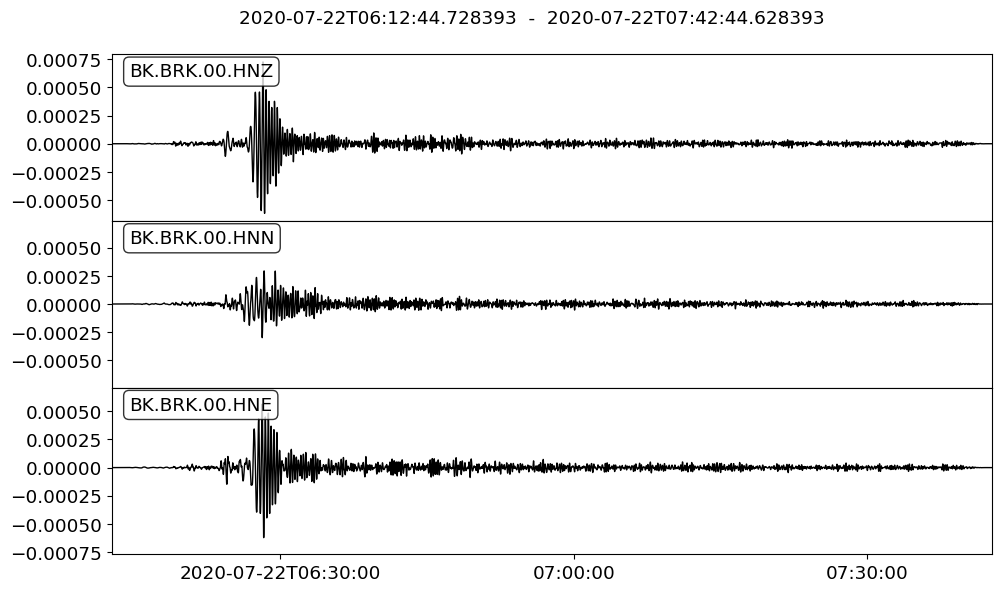

In [26]:
st2_zne = st2.copy()
st2_zne = get_zne_data (st2_zne, inv2, starttime)
_plot = st2_zne.plot(size=(1000,600))

## Rotating seismic data into ZRT coordinate 
get_baz to esimate the back azimuth and then use obspy rotate to covert ZNE data into ZRT data

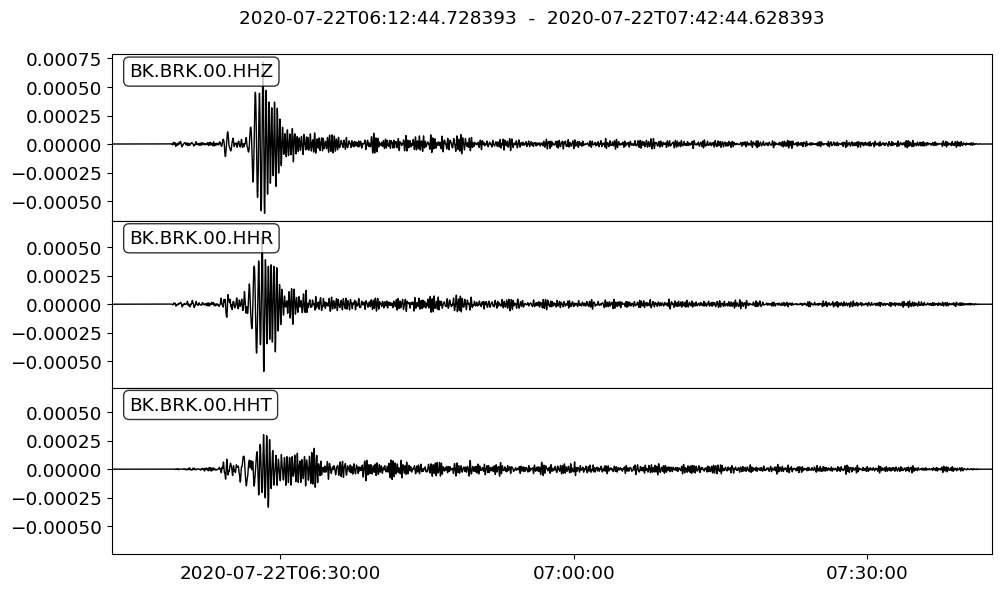

In [27]:
baz1 = get_baz(st1, inv1, evla, evlo)
st1_zrt = st1_zne.copy()
st1_zrt.rotate(method='NE->RT',back_azimuth=baz1[2])
_plot = st1_zrt.plot(size=(1000,600))

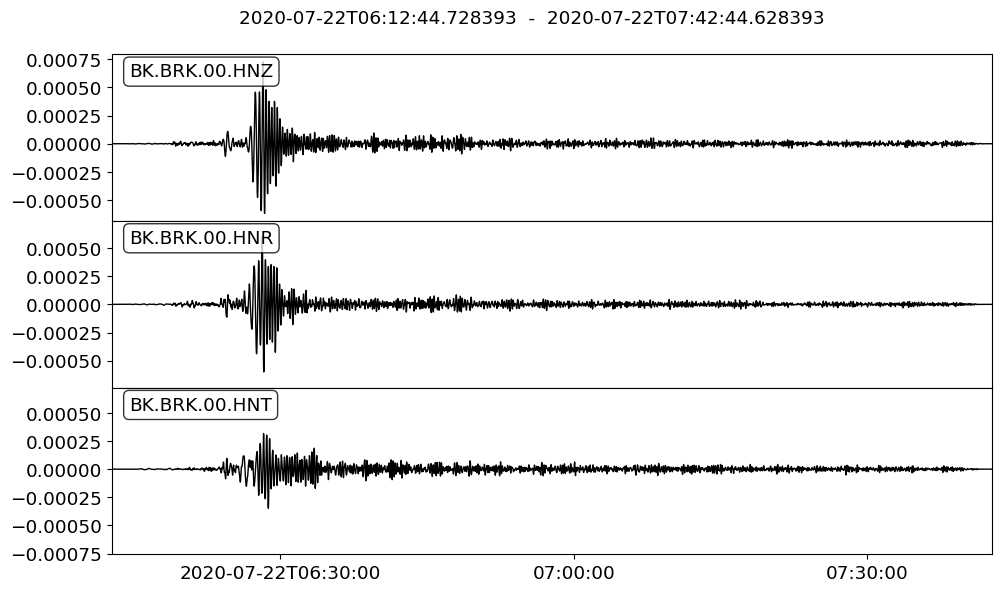

In [28]:
baz2 = get_baz(st2, inv2, evla, evlo)
st2_zrt = st2_zne.copy()
st2_zrt.rotate(method='NE->RT',back_azimuth=baz2[2])
_plot = st2_zrt.plot(size=(1000,600))

## Combining all streams
st_all includ all ZNERT data from two stations

In [29]:
#st_all = st2_zrt.copy() + st1_zrt.copy()
st_all = st2_zrt.copy() + st2_zne.select(component="E")  + st2_zne.select(component="N")  + st1_zrt.copy() + st1_zne.select(component="E") + st1_zne.select(component="N")


## Computing arrival time of Rayleigh wave
event ditance / Rvel (This example uses 4.2 km/s)

In [30]:
Rwave_arrival = baz2[0]/1000.0/Rvel
#print("# Rwave_arrival = ",Rwave_arrival)

## Trim seismic data


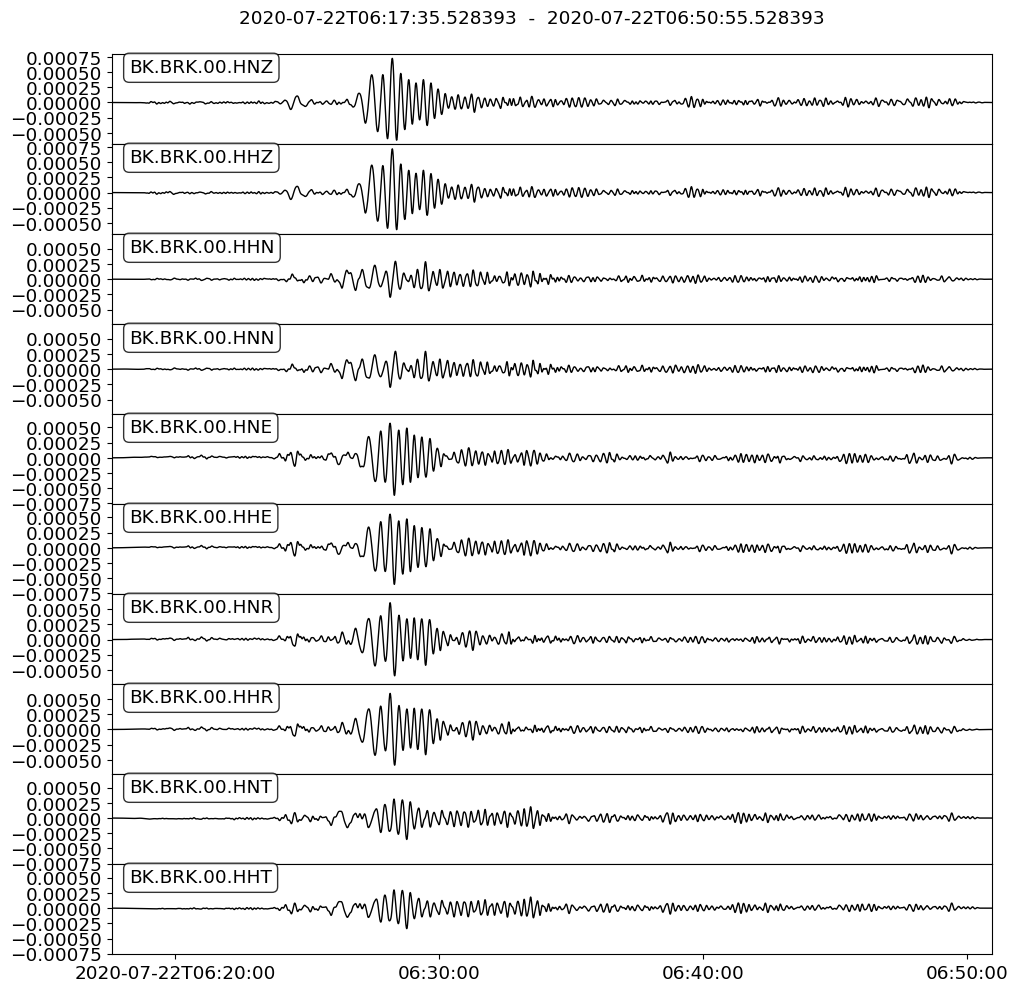

In [31]:
tw_start = origin_time + Rwave_arrival + tw_pre_tw
tw_end = tw_start + tw_trim

#st_select.trim(dt, dt + tw_trim)  
st_all.trim(tw_start, tw_end)  

st_all.detrend() # remove linear trend
st_all.detrend("demean") # demean
st_all.taper(0.05)

_plot = st_all.plot(size=(1000,1000))

## Waveform similarity 
This example will use transverse component data

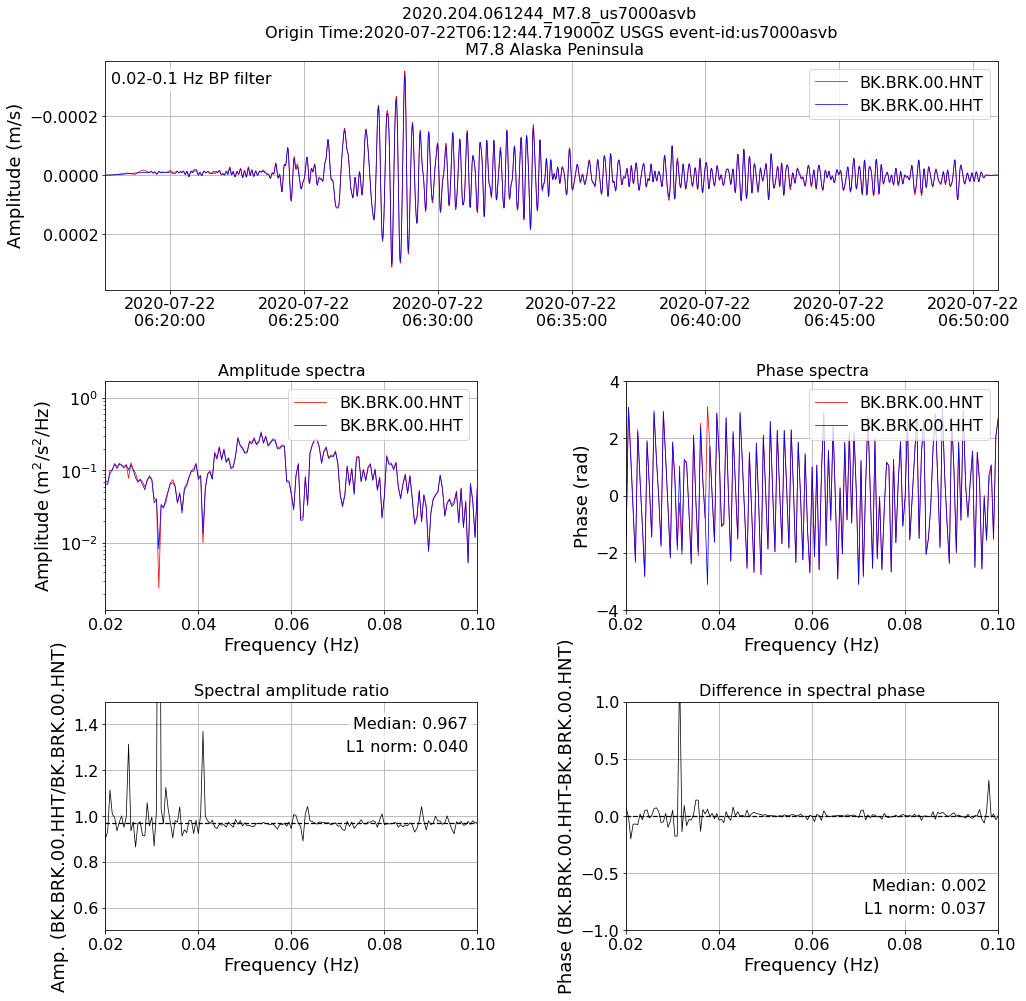

In [32]:
select_channel = "T"
#select_channel = ["N", "E" , "T", "R", "Z" ]
#select_channel = ["Z", "T", "R"]

for component in select_channel:
    st_select = st_all.select(component=component) 
    waveform_comparison(st_select, 1)
    #print(st_select)
    